In [63]:
__author__ = 'Brian Merino <brian.merino@noirlab.edu>'
__version__ = '2024' # yyyymmdd; version datestamp of this notebook
__keywords__ = ['Aladin','smash','des','delve']

# Displaying MOCs and HiPs in Aladin Lite v3

## Table of contents
* [Goals](#goals)
* [Summary](#summary)
* [Disclaimers and attribution](#disclaimer)
* [Imports and setup](#imports)
* [Create MOCs](#Create_MOCs)
* [About the dataset](#About)
* [Downloading data for reduction](#Downloading_Data)
* [Set up the DRAGONS logger](#DRAGONS_logger)
* [Create File Lists](#File_Lists)
* [Create Master Dark](#Master_dark)
* [Create Bad Pixel Mask](#BPM)
* [Create Master Flat Field](#Master_Flat)
* [Reduce Science Images](#Reduce_Science)
* [Display stacked final image](#Display_Image)
* [Clean-up (optional)](#Clean-up)

<a class="anchor" id="goals"></a>
# Goals
Showcase how to create Multi-Order Coverage maps (MOCs) and Hierarchical Progressive Surveys (HiPS) and display them on the Aladin Lite viewer.

The steps include downloading data from the Astro DataLab's data explorer, turning the data into MOCs and HiPs files, establish a local instance of the Aladin Lite viewer, and finally, display the files and explorer Aladin.


<a class="anchor" id="summary"></a>
# Summary
Aladin Lite is an interactable sky atlas that runs in your browser. 

Aladin makes it possible to explore the sky and has built in functionality that makes it possible to overlay images onto the map and identify objects included in databases. 

HiPS catalogs make it possible to see the locations of objects on the sky while MOCs display the footprints of surveys. MOCs make it possible to visualize overlaps in various surveys.

This notebook will demonstrate how to create and overlay several MOC files onto Aladin which would help identify overlapping datasets. It could also assist in preparing for a telescope proposal as you would be able to see whether or not any of the datasets hosted by the datalab contain the source of interest. 

In addition to MOCs, this notebook will also generate and display HiPs catlogs. While MOCs visualize survey footprints, HiPS will identify individual sources and provide information about each source when you place your curser over their points on Aladin. 


<a class="anchor" id="disclaimer"></a>
# Disclaimer & attribution
If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., <a href="http://dx.doi.org/10.1117/12.2057445">"The NOAO Data Laboratory: a conceptual overview"</a>, SPIE, 9149, 2014

* <a href="https://datalab.noirlab.edu/disclaimers.php">Data Lab disclaimer</a>

* DRAGONS publication: Labrie et al., <a href="https://ui.adsabs.harvard.edu/abs/2019ASPC..523..321L/abstract">"DRAGONS - Data Reduction for Astronomy from Gemini Observatory North and South"</a>, ASPC, 523, 321L 

* <a href="https://zenodo.org/record/7776065#.ZDg5qOzMLUI">DRAGONS open source software publication</a>

<a class="anchor" id="imports"></a>
# Imports and setup

This is the setup that is required to use the query client. The first thing to do is import the relevant Python modules.

In [15]:
!pip install ipyaladin mocpy

Defaulting to user installation because normal site-packages is not writeable


In [54]:
# Standard lib
from getpass import getpass

# Data Lab
from dl import authClient as ac, queryClient as qc, storeClient as sc
from dl.helpers.utils import convert

import astropy.units as u
from astropy.visualization.wcsaxes.frame import EllipticalFrame
from astropy.wcs import WCS
from astropy.table import Table

import matplotlib.pyplot as plt

from mocpy import MOC

from ipyaladin import Aladin

from astropy.table import QTable
#from astropy.table import Table

# Accessing the data

To create the MOC that we will ultimately overlay onto Aladin, we are going to use the mocpy library. 

The first thing we will need to do is obtain the data from the Astro Data Lab. For this example, we will be working with data from three different surveys; The **DE**Cam **L**ocal **V**olume **E**xploration Survey [**DELVE**](https://datalab.noirlab.edu/delve/index.php), The **S**urvey of the **MA**gellanic **S**tellar **H**istory [**SMASH**](https://datalab.noirlab.edu/smash/smash.php), and The **D**ark **E**negery **S**urvey [**DES**](https://datalab.noirlab.edu/des/index.php).

# Authentication
Much of the functionality of Data Lab can be accessed without explicitly logging in (the service then uses an anonymous login). But some capacities, for instance saving the results of your queries to your virtual storage space, require a login (i.e. you will need a registered user account).

If you need to log in to Data Lab, un-comment the cell below and execute it:

In [4]:
#token = ac.login(input("Enter user name: (+ENTER) "),getpass("Enter password: (+ENTER) "))
print(token)
ac.whoAmI()

bmerino95.3452.3452.$1$FDoEhEC6$G8osXeixeJ8G2N4VAzFgu1


'bmerino95'

In [5]:
query = 'SELECT TOP 25000 ra, dec, mag_auto_g, random_id FROM des_dr2.main WHERE random_id BETWEEN 25.0 AND 25.01'
response = qc.query(sql = query, fmt = 'csv', out='vos://des_dr2.csv')
#print (response)

In [6]:
sc.ls(name='vos://des_dr2.csv')

'des_dr2.csv'

In [7]:
data = sc.get(fr = 'vos://des_dr2.csv', to = '')
df = convert(data)
df

,ra,dec,mag_auto_g,random_id
0,357.428715,-44.637259,23.489162,25.000000
1,5.969949,-43.527294,24.286612,25.000000
2,22.207492,-32.286238,25.298033,25.000000
3,29.788967,-32.981351,21.148296,25.000000
4,20.727107,-2.892649,25.397202,25.000000
...,...,...,...,...
24995,54.172207,-27.747459,24.843880,25.003592
24996,84.988716,-43.217000,27.056932,25.003592
24997,84.363729,-40.298618,26.280462,25.003592
24998,88.931305,-36.130207,99.000000,25.003592


In [8]:
query2 = 'SELECT TOP 25000 ra, dec, mag_auto_g, random_id FROM delve_dr2.objects WHERE random_id BETWEEN 25.0 AND 25.01'
response2 = qc.query(sql = query2, fmt = 'csv', out='vos://delve_dr2.csv')
#print (response)

In [9]:
sc.ls(name='vos://delve_dr2.csv')

'delve_dr2.csv'

In [10]:
data2 = sc.get(fr = 'vos://delve_dr2.csv', to = '')
df2 = convert(data2)
df2

,ra,dec,mag_auto_g,random_id
0,316.881741,-28.795287,99.000000,25.000000
1,316.551473,-0.040920,99.000000,25.000000
2,352.731892,-15.496893,99.000000,25.000000
3,24.796882,-38.515716,99.000000,25.000000
4,41.790499,-35.662513,23.775738,25.000000
...,...,...,...,...
24995,223.429216,0.261509,20.466070,25.000996
24996,232.832520,-15.321605,19.765182,25.000996
24997,233.947717,-0.094942,99.000000,25.000996
24998,236.617734,-1.914219,21.536312,25.000996


# NOTE, while the other two catalogs have a column called mag_auto_g, the smash_dr2 catalog does not. In this catalog, the column is called gmag.

In [12]:
query3 = 'SELECT TOP 25000 ra, dec, gmag, random_id FROM smash_dr2.object WHERE random_id BETWEEN 25.0 AND 25.01'
response3 = qc.query(sql = query3, fmt = 'csv', out='vos://smash_dr2.csv')
#print (response)

In [13]:
sc.ls(name='vos://smash_dr2.csv')

'smash_dr2.csv'

In [14]:
data3 = sc.get(fr = 'vos://smash_dr2.csv', to = '')
df3 = convert(data3)
df3

,ra,dec,gmag,random_id
0,162.189122,-27.937445,25.859041,25.000000
1,8.216296,-72.550729,22.301060,25.000000
2,141.331479,-24.322865,25.586674,25.000004
3,150.680861,-75.469131,26.583921,25.000004
4,129.785524,-73.123489,99.990000,25.000004
...,...,...,...,...
24995,26.184753,-70.696753,99.990000,25.007020
24996,164.082881,-17.483517,25.556486,25.007025
24997,225.871730,-83.724109,99.990000,25.007025
24998,248.948190,-83.268695,21.105180,25.007025


# Now that all three datasets have been downloaded, we can now create Multi-Order Coverage maps (MOCs) for each of them using the mocpy library. 

In [36]:
#Provide MOC.from_longlat with ra and dec in degrees
#max_norder:The depth of the smallest HEALPix cells contained in the MOC.

ra1  = df['ra'].values
dec1 = df['dec'].values

m1 = MOC.from_lonlat(
    ra1.transpose() * u.deg,
    dec1.transpose() * u.deg,
    max_norder=5,
)

In [39]:
#Provide MOC.from_longlat with ra and dec in degrees
#max_norder:The depth of the smallest HEALPix cells contained in the MOC.

ra2  = df2['ra'].values
dec2 = df2['dec'].values

m2 = MOC.from_lonlat(
    ra2.transpose() * u.deg,
    dec2.transpose() * u.deg,
    max_norder=5,
)

In [40]:
#Provide MOC.from_longlat with ra and dec in degrees
#max_norder:The depth of the smallest HEALPix cells contained in the MOC.

ra3  = df3['ra'].values
dec3 = df3['dec'].values

m3 = MOC.from_lonlat(
    ra3.transpose() * u.deg,
    dec3.transpose() * u.deg,
    max_norder=5,
)

In [49]:
def plot(moc, title=""):
    fig = plt.figure(figsize=(15, 10))

    #Note for later:
    #I still need to update these WCS values
    #These values work, but the plot will look better after updating them.
    wcs = WCS(naxis=2)
    wcs.wcs.ctype = ["GLON-AIT", "GLAT-AIT"] #Hammer-Aitoff projection
    wcs.wcs.crval = [110.0, 0.0]             #Specify the value of the reference pixel
    wcs.wcs.cdelt = [-0.675, 0.675]
    wcs.wcs.crpix = [240.5, 120.5]

    ax = fig.add_subplot(1, 1, 1, projection=wcs, frame_class=EllipticalFrame)

    moc.fill(
        ax=ax,
        wcs=wcs,
        edgecolor="r",
        facecolor="r",
        linewidth=1.0,
        fill=True,
        alpha=0.5,
    )
    moc.border(ax=ax, wcs=wcs, color="black", alpha=1)

    plt.xlabel("ra")
    plt.ylabel("dec")
    if title:
        plt.title(title)
    plt.grid(color="black", linestyle="dotted")
    plt.show()
    plt.close()

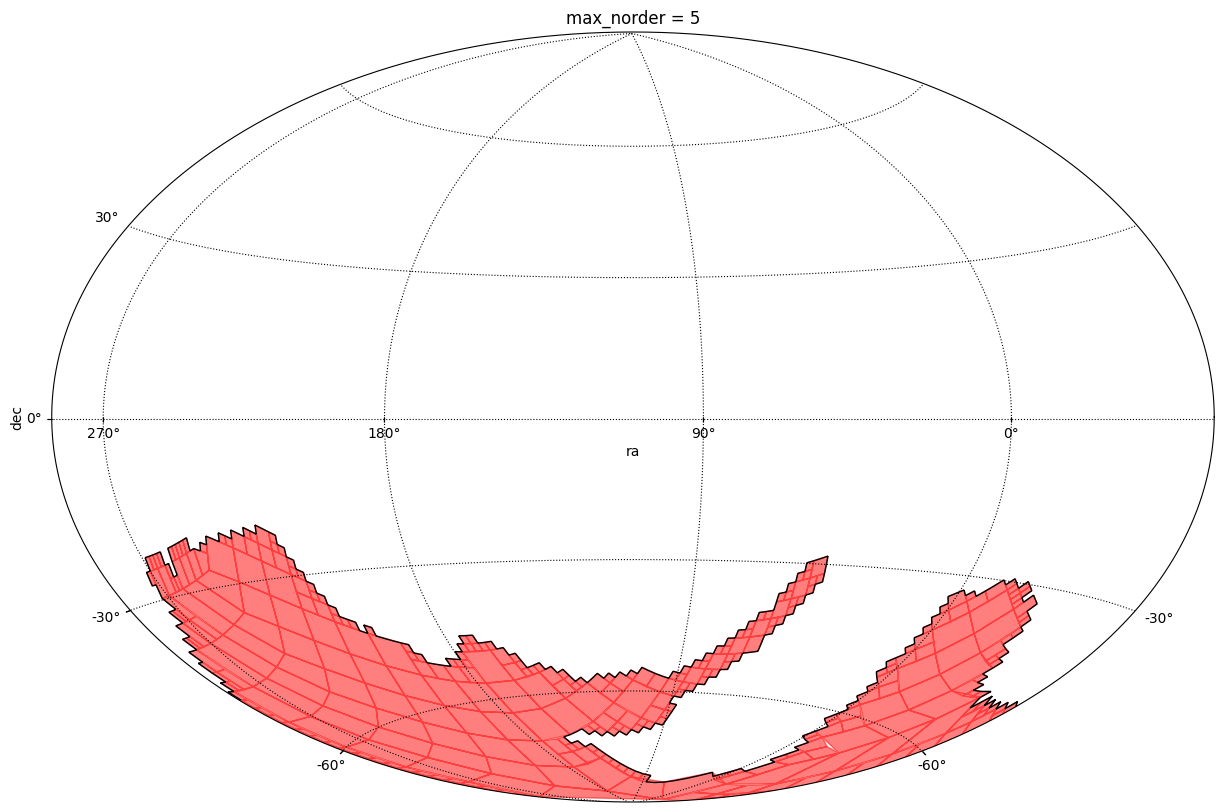

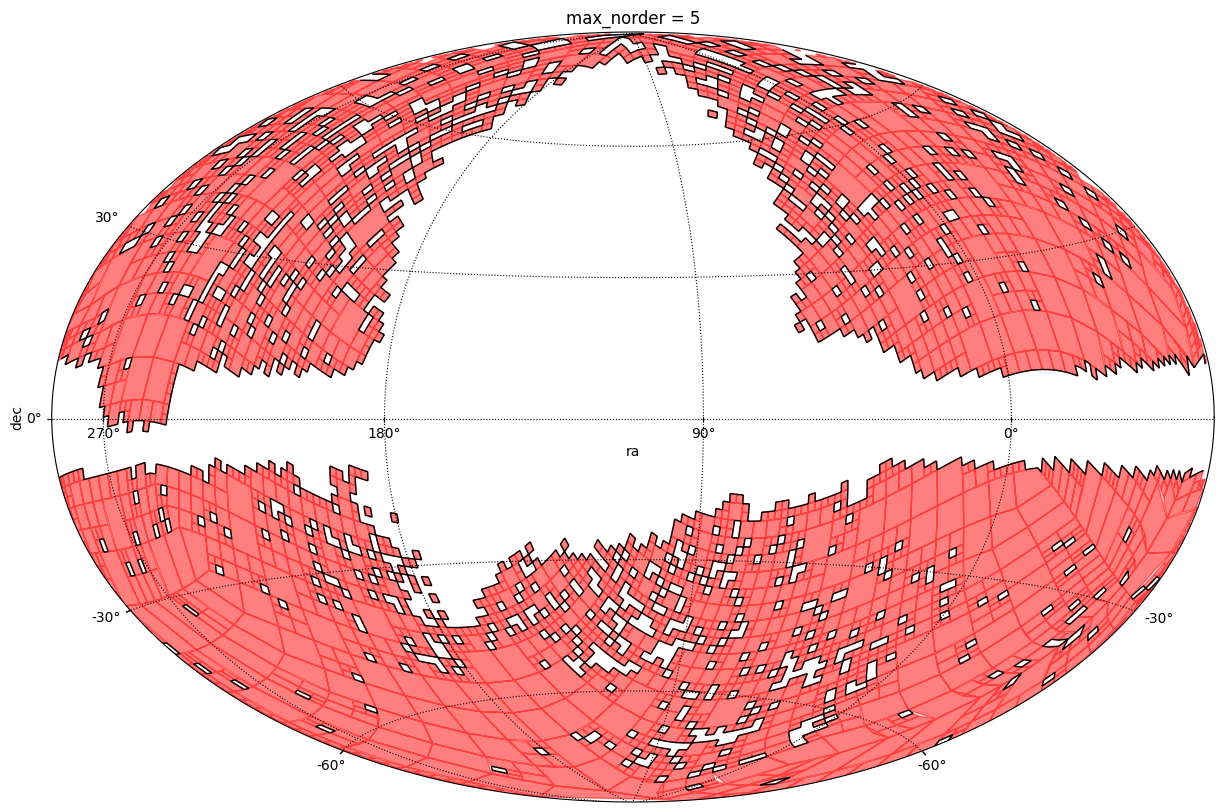

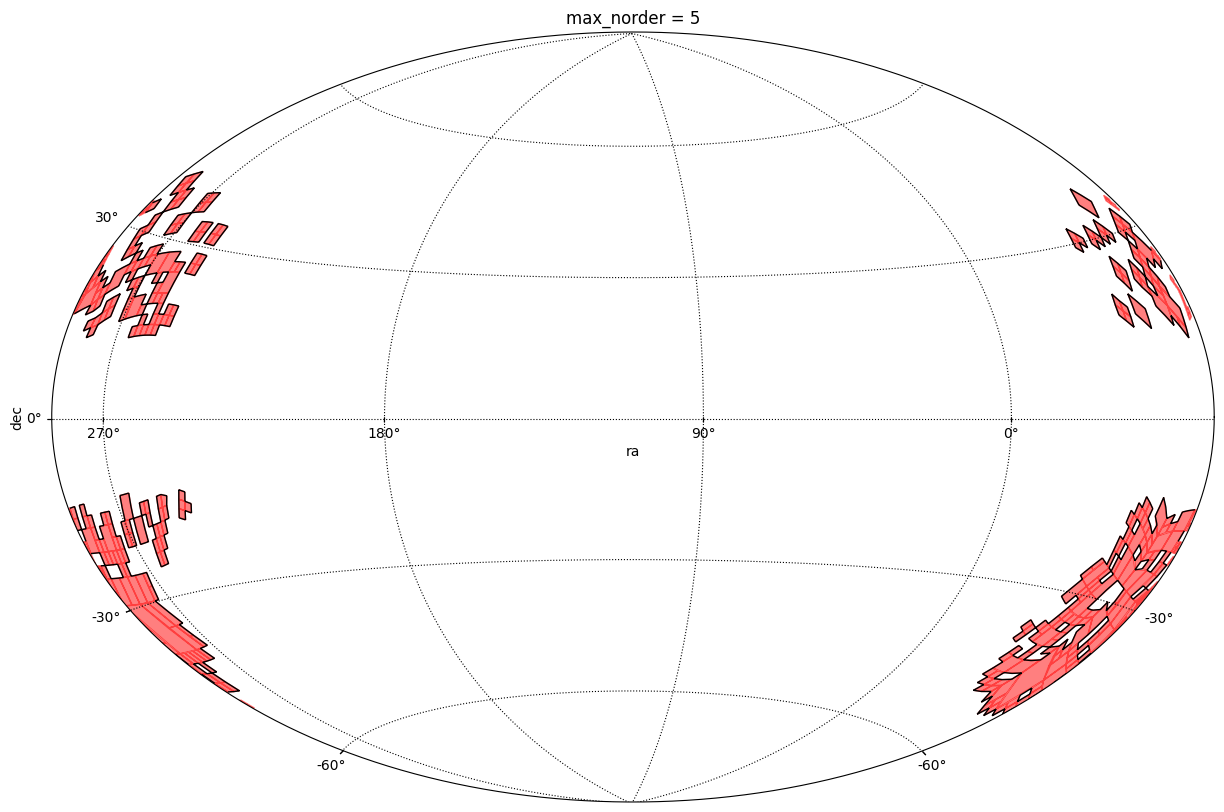

In [48]:
plot(moc=m1, title="max_norder = 5")
plot(moc=m2, title="max_norder = 5")
plot(moc=m3, title="max_norder = 5")

# Now that we have seen the footprint for each of the three surveys, lets see what they look like in Aladin.

In [60]:
aladin = Aladin(fov=2)
aladin

/data0/sw/anaconda3/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:687: DeprecationWarning: Deprecated in traitlets 4.1, use the instance .metadata dictionary directly, like x.metadata[key] or x.metadata.get(key, default)
  if trait.get_metadata('sync'):


Aladin(fov=2.0, init_options=['background_color', 'coo_frame', 'fov', 'full_screen', 'grid_color', 'grid_opaci…

# With Aladin initialized within the notebook, we will now need to add the mocs to it. Note, you do not need to call aladin after it has been initialized. Using add_moc will update the cell that is displaying Aladin. 

In [61]:
aladin.add_moc(m1, color='red',   name='des_dr2', opacity=0.4)
aladin.add_moc(m2, color='blue',  name='delve_dr2', opacity=0.4)
aladin.add_moc(m3, color='green', name='smash_dr2', opacity=0.4)

# Now lets plot the individual sources onto Aladin.

In [55]:
#des_dr2
new_table1 = QTable(
    [ra1,dec1],
    names=["ra","dec"])

In [57]:
#delve_dr2
new_table2 = QTable(
    [ra2,dec2],
    names=["ra","dec"])

In [58]:
#smash_dr2
new_table3 = QTable(
    [ra3,dec3],
    names=["ra","dec"])

In [62]:
aladin.add_table(new_table1,name='des_dr2')
aladin.add_table(new_table2,name='delve_dr2')
aladin.add_table(new_table3,name='smash_dr2')